<img src="../../images/QISKit.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

# _*Working with Different Backends*_ 

In this tutorial, we will first describe the various [backends](#backends) available in QISKit and how to find out more information about each of them, then we will explore how QISKit allows you to [compile and run](#compile) the same quantum circuit on different backends with different connectivities. 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
Jay Gambetta, Joe Hellmers, Anna Phan

## The Backends<a id='backends'></a>

At the core of QISKit is the ability to access different backends to run your quantum programs. These backends are real devices, online simulators, and local simulations. As we continue to increase the flexibility of QISKit we expect there to be many different backends. These will include new hardware with different number of qubits, connectivity, different gate sets, and simulators with different properties. 

Current devices: 
* [IBMQX2](https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx2) - a 5 qubit transmon bowtie chip.
* [IBMQX4](https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx4) - a 5 qubit transmon bowtie chip.
* [IBMQX5](https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx5) - a 16 qubit ladder chip.

Current simulators:
* QASM simulators - these simulate a quantum circuit and predict the outcomes of a quantum experiment.
    * Online QASM simulator – this runs online and can be used for up to 20 qubits with conditionals. 
    * Online HPC QASM simulator – this runs online and can be used for up to 32 qubits without conditionals. 
    * Local QASM simulator - this runs on your local machine, and should only be used for less than 10 qubits. 
* Local unitary simulator – predicts the unitary of a quantum circuit, ignoring measurement and conditional operations.

In [1]:
# Checking the version of PYTHON; we only support > 3.5
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')
    
from pprint import pprint

# import QISKit
from qiskit import QuantumProgram
import Qconfig

# import basic plotting tools
from qiskit.tools.visualization import plot_histogram

In [2]:
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config['url']) # set the APIToken and API url

### List and status 

To list all the backends that can be used we have provided the command: `Q_program.available_backends()`

In [3]:
pprint(Q_program.available_backends())

['ibmqx5',
 'ibmqx4',
 'ibmqx_hpc_qasm_simulator',
 'ibmqx2',
 'ibmqx_qasm_simulator',
 'local_qasm_simulator',
 'local_unitary_simulator']


The status can be obtained using the function `Q_program.get_backend_status()`:

In [4]:
pprint(Q_program.get_backend_status('ibmqx5'))

{'available': True, 'busy': False, 'pending_jobs': 46}


If the backend system is under maintenance it will be listed as unavailable:

In [5]:
pprint(Q_program.get_backend_status('ibmqx2'))

{'available': True, 'busy': False, 'pending_jobs': 0}


### Configuration

To get more information about a backend use this function: `Q_program.get_backend_configuration()`. This will return a subset of the following information, depending on backend: 
- `name` - backend name
- `description` - human readable description of the backend
- `simulator` - flag for labeling if the backend is simulator or not
- `n_qubits` - number of qubits in the backend
- `coupling_map` - device connectivity map where `i:[j]` represents that control qubit `i` is connected to target qubit(s) `j`
- `basis_gates` - gate set of the backend
- `online_date` - date the backend went online
- `chip_name` - code name for the backend
- `url` - url address to find more information about the backend
- `version` - version number that will iterate when changes are made to the backend

In [6]:
pprint(Q_program.get_backend_configuration('ibmqx2'))

{'basis_gates': 'u1,u2,u3,cx,id',
 'chip_name': 'Sparrow',
 'coupling_map': {0: [1, 2], 1: [2], 3: [2, 4], 4: [2]},
 'description': '5 transmon bowtie',
 'n_qubits': 5,
 'name': 'ibmqx2',
 'online_date': '2017-01-10T12:00:00.000Z',
 'simulator': False,
 'url': 'https://ibm.biz/qiskit-ibmqx2',
 'version': '1'}


In [7]:
pprint(Q_program.get_backend_configuration('local_qasm_simulator'))

{'basis_gates': 'u1,u2,u3,cx,id',
 'coupling_map': 'all-to-all',
 'description': 'A python simulator for qasm files',
 'name': 'local_qasm_simulator',
 'simulator': True,
 'url': 'https://github.com/IBM/qiskit-sdk-py'}


### Additional Device Information

For the devices, you can find out lots more information, such as parameter and calibration data using `Q_program.get_backend_calibration()` and `Q_program.get_backend_parameters()`:

In [8]:
print(Q_program.get_backend_calibration('ibmqx4'))

{'last_update_date': '2018-03-12T11:38:29.000Z', 'qubits': [{'gateError': {'date': '2018-03-12T11:38:29Z', 'value': 0.000858490762927322}, 'name': 'Q0', 'readoutError': {'date': '2018-03-12T11:38:29Z', 'value': 0.046}}, {'gateError': {'date': '2018-03-12T11:38:29Z', 'value': 0.0006867731322012238}, 'name': 'Q1', 'readoutError': {'date': '2018-03-12T11:38:29Z', 'value': 0.054}}, {'gateError': {'date': '2018-03-12T11:38:29Z', 'value': 0.00197489316929661}, 'name': 'Q2', 'readoutError': {'date': '2018-03-12T11:38:29Z', 'value': 0.128}}, {'gateError': {'date': '2018-03-12T11:38:29Z', 'value': 0.00197489316929661}, 'name': 'Q3', 'readoutError': {'date': '2018-03-12T11:38:29Z', 'value': 0.087}}, {'gateError': {'date': '2018-03-12T11:38:29Z', 'value': 0.001803112096824766}, 'name': 'Q4', 'readoutError': {'date': '2018-03-12T11:38:29Z', 'value': 0.045}}], 'multi_qubit_gates': [{'qubits': [1, 0], 'type': 'CX', 'gateError': {'date': '2018-03-12T11:38:29Z', 'value': 0.019933034541237543}, 'name':

In [9]:
print(Q_program.get_backend_parameters('ibmqx4'))

{'last_update_date': '2018-03-12T11:38:29.000Z', 'fridge_parameters': {'cooldownDate': '2017-09-07', 'Temperature': {'date': '2018-03-12T11:38:29Z', 'value': 0.021, 'unit': 'K'}}, 'qubits': [{'name': 'Q0', 'buffer': {'date': '2018-03-12T11:38:29Z', 'value': 10, 'unit': 'ns'}, 'gateTime': {'date': '2018-03-12T11:38:29Z', 'value': 50, 'unit': 'ns'}, 'T2': {'date': '2018-03-12T11:38:29Z', 'value': 35.4, 'unit': 'µs'}, 'T1': {'date': '2018-03-12T11:38:29Z', 'value': 55.4, 'unit': 'µs'}, 'frequency': {'date': '2018-03-12T11:38:29Z', 'value': 5.24466, 'unit': 'GHz'}}, {'name': 'Q1', 'buffer': {'date': '2018-03-12T11:38:29Z', 'value': 10, 'unit': 'ns'}, 'gateTime': {'date': '2018-03-12T11:38:29Z', 'value': 50, 'unit': 'ns'}, 'T2': {'date': '2018-03-12T11:38:29Z', 'value': 61.7, 'unit': 'µs'}, 'T1': {'date': '2018-03-12T11:38:29Z', 'value': 55.3, 'unit': 'µs'}, 'frequency': {'date': '2018-03-12T11:38:29Z', 'value': 5.30492, 'unit': 'GHz'}}, {'name': 'Q2', 'buffer': {'date': '2018-03-12T11:38:2

## Compiling and Running on Different Devices <a id='compile'></a>

Each of the hardware devices has a different configuration, in terms of number of qubits and their connectivity. For example, even though both `ibmqx2` and `ibmqx4` have 5 qubits in a `bowtie` layout, their connectivity, in terms of what `CNOT` gates are available, is different. This means that circuits written for one device may not run on another device without modification. 

In QISKit, we provide a `compile` function to rewrite circuits so they can be run with a particular configuration. This is done through specifying a `coupling map`. Let's go through a simple example of creating an entangled Bell state on `ibmqx2`, then on `ibmqx4` using qubits `0` and `1`. More information about the `compile` function with a more complex example can be found in the [appendix](../../appendix/advanced_qiskit/compiling_and_running.ipynb).

First let's write the code for creating this state and measuring it, using a `CNOT` from qubit `0` to qubit `1`, and look at the created QASM:

In [10]:
# Creating registers
q2 = Q_program.create_quantum_register("q2", 2)
c2 = Q_program.create_classical_register("c2", 2)

# quantum circuit to make an entangled state 
bell = Q_program.create_circuit("bell", [q2], [c2])
bell.h(q2[0])
bell.cx(q2[0], q2[1])
bell.measure(q2[0], c2[0])
bell.measure(q2[1], c2[1])
print(Q_program.get_qasm('bell'))

OPENQASM 2.0;
include "qelib1.inc";
qreg q2[2];
creg c2[2];
h q2[0];
cx q2[0],q2[1];
measure q2[0] -> c2[0];
measure q2[1] -> c2[1];



Now let's get the coupling map for `ibmqx2`, compile the circuit to run on that device and look at the created QASM:

In [11]:
ibmqx2_backend = Q_program.get_backend_configuration('ibmqx2')
ibmqx2_coupling = ibmqx2_backend['coupling_map']

compile_ibmqx2 = Q_program.compile(['bell'], backend='ibmqx2', coupling_map=ibmqx2_coupling)
print(Q_program.get_compiled_qasm(compile_ibmqx2, 'bell'))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c2[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
measure q[1] -> c2[1];
measure q[0] -> c2[0];



Note that while the `compile` function has replaced the `h` gate with an equivalent `u2` gate, it hasn't changed anything else. This is because a `CNOT` from qubit `0` to qubit `1` is possible on `ibmqx2`.

Now let's get the coupling map for `ibmqx4`, compile the circuit to run on that device and look at the created QASM:

In [12]:
ibmqx4_backend = Q_program.get_backend_configuration('ibmqx4')
ibmqx4_coupling = ibmqx4_backend['coupling_map']

compile_ibmqx4 = Q_program.compile(['bell'], backend='ibmqx4', coupling_map=ibmqx4_coupling)
print(Q_program.get_compiled_qasm(compile_ibmqx4, 'bell'))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c2[2];
u2(0.0,3.141592653589793) q[1];
cx q[1],q[0];
measure q[0] -> c2[1];
measure q[1] -> c2[0];



Note this time the `compile` function ended with a final circuit containing a `h` gate on qubit `1` and a `CNOT` from qubit `1` to qubit `0` to create an equivalent entangled bell state.

This `compile` functionality also exists in the `execute` function, where you can specify a `coupling_map`, and your circuit will be modified for that configuration, then executed on the specified backend. 

Below is the same circuit compiled using different configurations, but run on the local simulator backend. Try running them yourself on the devices (checking that they are available first)!

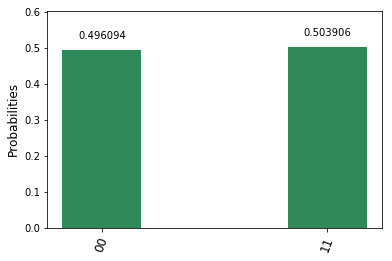

In [13]:
run_ibmqx2 = Q_program.execute(["bell"], backend="local_qasm_simulator", coupling_map=ibmqx2_coupling)
plot_histogram(run_ibmqx2.get_counts("bell"))

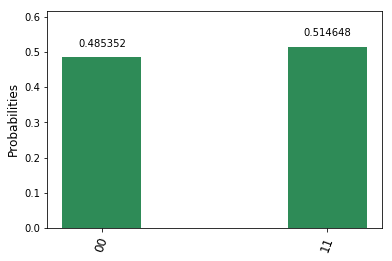

In [14]:
run_ibmqx4 = Q_program.execute(["bell"], backend="local_qasm_simulator", coupling_map=ibmqx4_coupling)
plot_histogram(run_ibmqx4.get_counts("bell"))

In [15]:
#%run "../version.ipynb"